In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
import time
import math
from script.rs_pca import *

In [3]:
##  UCITAVANJE SKUPA PODATAKA
##
##  S obzirom na to da je skup podataka vrlo velik (5 193 124 redaka), mjerit
##  cemo i vrijeme potrebno za njegovo ucitavanje.  Podatci bi se, medutim, iz
##  CSV datoteke puno brze ucitali da se datumi ne parsiraju, nego da ostanu
##  stringovi, ali vjerojatno ce nam datumi ionako biti potrebni u datumskom
##  obliku pa ih je bolje odmah takve i ucitati.  Stoga, jednom kada se CSV
##  ucita, sprema se pickle cijelog skupa podataka tako da svaki sljedeci put
##  ucitavanje bude puno brze (ako datoteka s pickle-om postoji, automatski se
##  skup podataka cita iz nje; CSV se cita tek ako datoteka s pickle-om ne
##  postoji).

# Pocni mjeriti vrijeme.
t0 = time.time()


# Ucitaj skup podataka.  Prvo se pokusava ucitati pickle iz datoteke
# `training_dataset_enc.pkl', a, ako ta datoteka ne postoji, onda se ucitava
# tablica u CSV obliku iz `training_dataset_enc.csv' i odmah se sprema pickle u
# datoteku `training_dataset_enc.pkl' za brze ucitavanje ubuduce.
df = None
try:
    df = pd.read_pickle('../data/training_dataset_enc_extra.pkl')
except FileNotFoundError:
    df = pd.read_csv(
        '../data/training_dataset_enc_extra.csv',
        index_col = 0,
        parse_dates = [
            'DATUM_OTVARANJA',
            'PLANIRANI_DATUM_ZATVARANJA'
        ],
        infer_datetime_format = True
    )
    df.reset_index(drop = True, inplace = True)
    df.KLIJENT_ID = df.KLIJENT_ID.astype(
        pd.api.types.CategoricalDtype(
            categories = np.sort(
                df.KLIJENT_ID[pd.notnull(df.KLIJENT_ID)].unique()
            ),
            ordered = False
        )
    )
    df.OZNAKA_PARTIJE = df.OZNAKA_PARTIJE.astype(
        pd.api.types.CategoricalDtype(
            categories = np.sort(
                df.OZNAKA_PARTIJE[pd.notnull(df.OZNAKA_PARTIJE)].unique()
            ),
            ordered = False
        )
    )
    df.VALUTA = df.VALUTA.astype(
        pd.api.types.CategoricalDtype(
            categories = np.sort(df.VALUTA[pd.notnull(df.VALUTA)].unique()),
            ordered = False
        )
    )
    df.VRSTA_KLIJENTA = df.VRSTA_KLIJENTA.astype(
        pd.api.types.CategoricalDtype(
            categories = np.sort(
                df.VRSTA_KLIJENTA[pd.notnull(df.VRSTA_KLIJENTA)].unique()
            ),
            ordered = False
        )
    )
    df.PROIZVOD = df.PROIZVOD.astype(
        pd.api.types.CategoricalDtype(
            categories = np.sort(df.PROIZVOD[pd.notnull(df.PROIZVOD)].unique()),
            ordered = False
        )
    )
    df.VRSTA_PROIZVODA = df.VRSTA_PROIZVODA.astype(
        pd.api.types.CategoricalDtype(
            categories = np.sort(
                df.VRSTA_PROIZVODA[pd.notnull(df.VRSTA_PROIZVODA)].unique()
            ),
            ordered = False
        )
    )
    df.TIP_KAMATE = df.TIP_KAMATE.astype(
        pd.api.types.CategoricalDtype(
            categories = np.sort(
                df.TIP_KAMATE[pd.notnull(df.TIP_KAMATE)].unique()
            ),
            ordered = False
        )
    )
    df.to_pickle('../data/training_dataset_enc_extra.pkl')

# Zavrsi mjerenje vremena.
t1 = time.time()

# Izracunaj vremenski period od t0 do t1 u sekundama.
d = float(t1 - t0)

# Ispisi vrijeme.
print(
    'Trajanje ucitavanja: {h:d}h {m:02d}m {s:06.3f}s ({S:.3f}s)'.format(
        h = int(math.floor(d / 3600)),
        m = int(math.floor((d - 3600 * int(math.floor(d / 3600))) / 60)),
        s = d - 60 * int(math.floor(d / 60)),
        S = d
    )
)

# Oslobodi memoriju.
del d
del t0
del t1


/home/lunagli/anaconda3/lib/python3.7/site-packages/numpy/lib/arraysetops.py:569: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


Trajanje ucitavanja: 0h 00m 04.107s (4.107s)


In [4]:
df['DATUM_OTVARANJA'] = pd.to_numeric(df['DATUM_OTVARANJA'])

In [5]:
df['PLANIRANI_DATUM_ZATVARANJA'] = pd.to_numeric(df['PLANIRANI_DATUM_ZATVARANJA'])

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1154519 entries, 0 to 1154518
Data columns (total 13 columns):
KLIJENT_ID                    1154519 non-null category
OZNAKA_PARTIJE                1154519 non-null category
DATUM_OTVARANJA               1154519 non-null int64
PLANIRANI_DATUM_ZATVARANJA    1154519 non-null int64
STAROST                       1154519 non-null int64
UGOVORENI_IZNOS               1154098 non-null float64
VISINA_KAMATE                 1152727 non-null float64
VRSTA_KLIJENTA                1154519 non-null category
VRSTA_PROIZVODA               1154519 non-null category
PROIZVOD                      1154519 non-null category
VALUTA                        1154519 non-null category
TIP_KAMATE                    1154519 non-null category
PRIJEVREMENI_RASKID           1154519 non-null int64
dtypes: category(7), float64(2), int64(4)
memory usage: 103.3 MB


In [7]:
cat_df = df[['VRSTA_KLIJENTA', 'VRSTA_PROIZVODA', 'PROIZVOD', 'VALUTA', 'TIP_KAMATE']]

In [8]:
pca = RS_PCA()

In [9]:
pca.fit(cat_df, n_simultaneous_instances=50_000)

<RS_PCA: ('VRSTA_KLIJENTA', 'VRSTA_PROIZVODA', 'PROIZVOD', 'VALUTA', 'TIP_KAMATE')>

In [18]:
np.cumsum(pca.explained_variance_ratios)

array([0.49138753, 0.64329848, 0.73191199, 0.81417076, 0.85399414,
       0.8877198 , 0.91199034, 0.93149268, 0.94447823, 0.9526258 ,
       0.95919354, 0.96449603, 0.96960022, 0.97431838, 0.97769449,
       0.98041746, 0.98302008, 0.98521234, 0.98737357, 0.98944158,
       0.99101932, 0.99252914, 0.99366516, 0.99478777, 0.99573765,
       0.99667104, 0.99742907, 0.99798024, 0.99841099, 0.99876643,
       0.99907888, 0.9993327 , 0.99952824, 0.99969072, 0.99976175,
       0.99981953, 0.99987648, 0.9999085 , 0.99993653, 0.99996234,
       0.99998133, 0.99998616, 0.99998962, 0.9999921 , 0.99999437,
       0.99999648, 0.99999848, 0.9999994 , 1.        , 1.        ])

In [19]:
y = pca.transform(cat_df.sample(50_000), 20)

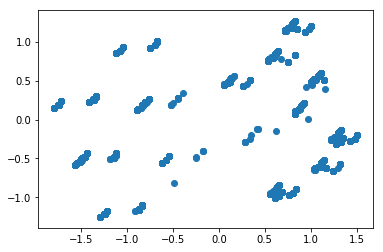

In [20]:
plt.scatter(y[:,0],y[:,1])

In [ ]:
pca.shape

In [ ]:
coef,valeuses = pca.reinterpret(10)

In [ ]:
coef

In [ ]:
valeuses

In [21]:
cat_df = cat_df.copy()

In [22]:
df.drop(columns=cat_df.columns, inplace=True)

In [23]:
df=pd.concat([df, pd.DataFrame(pca.transform(cat_df, 20))], axis=1)

In [24]:
df = pd.concat([df.drop(columns='PRIJEVREMENI_RASKID'), df.PRIJEVREMENI_RASKID], axis=1)

In [39]:
import pickle

df.to_pickle('./RSiPCAnaKategorijskim.pkl')

In [25]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1154519 entries, 0 to 1154518
Data columns (total 28 columns):
KLIJENT_ID                    1154519 non-null category
OZNAKA_PARTIJE                1154519 non-null category
DATUM_OTVARANJA               1154519 non-null int64
PLANIRANI_DATUM_ZATVARANJA    1154519 non-null int64
STAROST                       1154519 non-null int64
UGOVORENI_IZNOS               1154098 non-null float64
VISINA_KAMATE                 1152727 non-null float64
0                             1154519 non-null float64
1                             1154519 non-null float64
2                             1154519 non-null float64
3                             1154519 non-null float64
4                             1154519 non-null float64
5                             1154519 non-null float64
6                             1154519 non-null float64
7                             1154519 non-null float64
8                             1154519 non-null float64
9          

In [26]:
from sklearn.decomposition import PCA

In [27]:
df.dropna(axis=0,how='any', inplace=True)

In [37]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1152361 entries, 4 to 1154518
Data columns (total 28 columns):
KLIJENT_ID                    1152361 non-null category
OZNAKA_PARTIJE                1152361 non-null category
DATUM_OTVARANJA               1152361 non-null int64
PLANIRANI_DATUM_ZATVARANJA    1152361 non-null int64
STAROST                       1152361 non-null int64
UGOVORENI_IZNOS               1152361 non-null float64
VISINA_KAMATE                 1152361 non-null float64
0                             1152361 non-null float64
1                             1152361 non-null float64
2                             1152361 non-null float64
3                             1152361 non-null float64
4                             1152361 non-null float64
5                             1152361 non-null float64
6                             1152361 non-null float64
7                             1152361 non-null float64
8                             1152361 non-null float64
9          

In [33]:
pca = PCA(n_components=3)
pca.fit(np.array(df.iloc[:,2:-1]))

PCA(copy=True, iterated_power='auto', n_components=3, random_state=None,
  svd_solver='auto', tol=0.0, whiten=False)

In [34]:
transformed = pca.transform(np.array(df.iloc[:,2:-1]))

In [30]:
I = np.random.choice(transformed.shape[0], 50_000, replace = False)

In [ ]:
transformed

In [35]:
transformed2 = transformed[I,:]

<IPython.core.display.Javascript object>


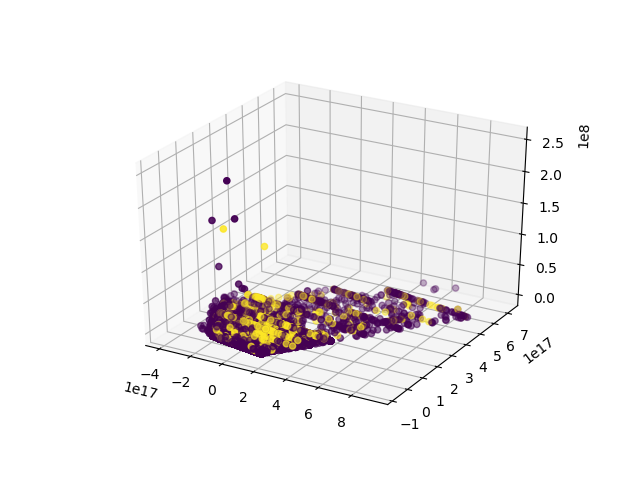

In [36]:
%matplotlib notebook
from mpl_toolkits.mplot3d import Axes3D
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(transformed2[:,0],transformed2[:,1],transformed2[:,2], c= df['PRIJEVREMENI_RASKID'].iloc[I])


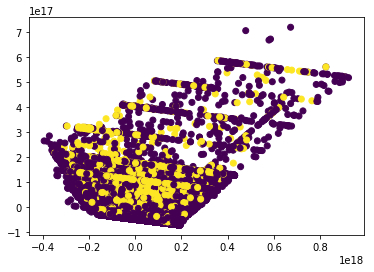

In [32]:
plt.scatter(transformed2[:,0], transformed2[:,1], c=df['PRIJEVREMENI_RASKID'].iloc[I])